In [13]:
!nvidia-smi

Fri Feb 10 11:58:13 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 528.24       Driver Version: 528.24       CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name            TCC/WDDM | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ... WDDM  | 00000000:01:00.0 Off |                  N/A |
| N/A   55C    P8    N/A /  N/A |   1853MiB /  2048MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [14]:
!nvcc -V

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2022 NVIDIA Corporation
Built on Wed_Sep_21_10:41:10_Pacific_Daylight_Time_2022
Cuda compilation tools, release 11.8, V11.8.89
Build cuda_11.8.r11.8/compiler.31833905_0


In [ ]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 12151677134713004603
xla_global_id: -1
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 1297474971
locality {
  bus_id: 1
  links {
  }
}
incarnation: 6695397469065531639
physical_device_desc: "device: 0, name: NVIDIA GeForce MX450, pci bus id: 0000:01:00.0, compute capability: 7.5"
xla_global_id: 416903419
]


In [1]:
# Keras e TF

import tensorflow as tf 
from tensorflow import keras
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Conv2D, Conv1D, MaxPooling2D, Dense, Flatten, BatchNormalization, Activation, AveragePooling2D, Input, Flatten, Dropout
from keras.callbacks import ModelCheckpoint

# Sk-Learn
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report,confusion_matrix, ConfusionMatrixDisplay, roc_curve, roc_auc_score, RocCurveDisplay, accuracy_score, classification_report, confusion_matrix
# Base
import os 
from matplotlib import pyplot as plt
import seaborn as sns # 
import numpy as np #
import pandas as pd # 

import pydot
import pydotplus
from pydotplus import graphviz

In [2]:
# Set visualization size for figures 
plt.rcParams['figure.figsize'] = [7,7] # width, height

# Image generator

In this neural network, pre-processed and enanchment-improved data are used

In [3]:
batch_size = 32 

train_path = 'C:/Users/marco/Desktop/Local_Documents/data/COVIDx-splitted-resized-112-process-enanch-augm/train'
test_path = 'C:/Users/marco/Desktop/Local_Documents/data/COVIDx-splitted-resized-112-process-enanch-augm/test'

train_datagen = ImageDataGenerator(rescale=1./255., validation_split=0.2)
test_datagen = ImageDataGenerator(rescale=1./255.)

In [4]:
train_data = train_datagen.flow_from_directory(
        train_path,  
        target_size=(112, 112),  # Lo inserisco per precauzione
        batch_size=batch_size,
        seed=123,
        shuffle=True,
        subset='training',
        class_mode='categorical')

Found 37700 images belonging to 3 classes.


In [5]:
validation_data = train_datagen.flow_from_directory(
        train_path,  
        target_size=(112, 112),  # Lo inserisco per precauzione
        batch_size=batch_size,
        seed=123,
        shuffle=True,
        subset='validation',
        class_mode='categorical')

Found 9422 images belonging to 3 classes.


In [6]:
# Test set
test_data = test_datagen.flow_from_directory(
        test_path,  
        target_size=(112, 112),  # Lo inserisco per precauzione
        batch_size=batch_size,
        shuffle=False,
        class_mode='categorical')

Found 397 images belonging to 3 classes.


# Architecture Definition

In [16]:
#Definizione del CallBacks: Early stopper sulla loss di validazione
early_stopper = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=100)

In [17]:
version = "v1"
img_size = '112'
checkpoint_filepath = f'C:/Users/marco/Desktop/Local_Documents/models/Processing_Enanch_Oversampling_Augm/dcnn_model_{img_size}_{version}_val_acc_best.hdf5'
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)

In [18]:
num_classes = 3
inputs = keras.Input((112,112,3))

x = inputs

x = keras.layers.Conv2D(16, 3, padding ="same", strides=1)(x)
x = keras.layers.Activation('relu')(x)
x = keras.layers.BatchNormalization()(x)

x = keras.layers.Conv2D(32, 3,  padding ="same", strides=1)(x)
x = keras.layers.Activation('relu')(x)
x = keras.layers.MaxPooling2D(pool_size=(3,3), strides=(3,3))(x)
x = keras.layers.Dropout(0.2)(x)

x = keras.layers.Conv2D(64, 3,  padding ="same", strides=1)(x)
x = keras.layers.Activation('relu')(x)
x = keras.layers.BatchNormalization()(x)

x = keras.layers.Conv2D(128, 2,  padding ="same", strides=1)(x)
x = keras.layers.Activation('relu')(x)

x = keras.layers.MaxPooling2D(pool_size=(2,2), strides=(3,3))(x)

x = keras.layers.Dropout(0.2)(x)

# x = keras.layers.GlobalMaxPool2D()(x)
x = keras.layers.Flatten()(x)

x = keras.layers.Dense(128, activation='relu')(x)
x = keras.layers.Dropout(0.5)(x)

# x = keras.layers.Dense(512, activation='relu')(x)
# x = keras.layers.Dropout(0.5)(x)

# x = keras.layers.Dense(1000, activation='relu')(x)
# x = keras.layers.Dropout(0.5)(x)

outputs = keras.layers.Dense(num_classes, activation='softmax')(x)
net_dcnn_112_process_enanch_over = keras.Model(inputs, outputs)



In [19]:
net_dcnn_112_process_enanch_over.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 112, 112, 3)]     0         
                                                                 
 conv2d_4 (Conv2D)           (None, 112, 112, 16)      448       
                                                                 
 activation_4 (Activation)   (None, 112, 112, 16)      0         
                                                                 
 batch_normalization_2 (Batc  (None, 112, 112, 16)     64        
 hNormalization)                                                 
                                                                 
 conv2d_5 (Conv2D)           (None, 112, 112, 32)      4640      
                                                                 
 activation_5 (Activation)   (None, 112, 112, 32)      0         
                                                           

# Model Fit

In [20]:
METRICS = [ 
      keras.metrics.CategoricalAccuracy(name='accuracy'),
      keras.metrics.Precision(name='precision'),
      keras.metrics.Recall(name='recall'),
      keras.metrics.AUC(name='auc'),
      keras.metrics.TopKCategoricalAccuracy(name='top 2 accuracy', k=2),
]
OPTIMIZER = keras.optimizers.Adam(learning_rate=0.0001)

In [21]:
# batch size 
step_per_epoch_train = len(train_data.labels) // batch_size
print(step_per_epoch_train)
step_per_epoch_val = len(validation_data.labels) // batch_size
print(step_per_epoch_val)

1178
294


In [22]:
net_dcnn_112_process_enanch_over.compile(loss=keras.losses.categorical_crossentropy,
            optimizer = OPTIMIZER,
            metrics=METRICS)

In [23]:
history_dcnn_over = net_dcnn_112_process_enanch_over.fit(train_data,
          epochs=50,
          steps_per_epoch=step_per_epoch_train,
          validation_data=validation_data,
          validation_steps=step_per_epoch_val,
          workers = 3,
          callbacks=[model_checkpoint_callback, early_stopper])

Epoch 1/50
1178/1178 [==============================] - 115s 91ms/step - loss: 0.6400 - accuracy: 0.7212 - precision: 0.7652 - recall: 0.6549 - auc: 0.8872 - top 2 accuracy: 0.9361 - val_loss: 0.4420 - val_accuracy: 0.8340 - val_precision: 0.8709 - val_recall: 0.7890 - val_auc: 0.9532 - val_top 2 accuracy: 0.9691
Epoch 2/50
1178/1178 [==============================] - 106s 90ms/step - loss: 0.4965 - accuracy: 0.7944 - precision: 0.8211 - recall: 0.7587 - auc: 0.9322 - top 2 accuracy: 0.9652 - val_loss: 0.3611 - val_accuracy: 0.8597 - val_precision: 0.8747 - val_recall: 0.8384 - val_auc: 0.9660 - val_top 2 accuracy: 0.9862
Epoch 3/50
1178/1178 [==============================] - 105s 89ms/step - loss: 0.4334 - accuracy: 0.8244 - precision: 0.8446 - recall: 0.7988 - auc: 0.9483 - top 2 accuracy: 0.9748 - val_loss: 0.3144 - val_accuracy: 0.8829 - val_precision: 0.8924 - val_recall: 0.8672 - val_auc: 0.9751 - val_top 2 accuracy: 0.9904
Epoch 4/50
1178/1178 [==============================] -

In [24]:
np.save(f'C:/Users/marco/Desktop/Local_Documents/models/Processing_Enanch_Oversampling_Augm/dcnn_history_{img_size}_{version}.npy',
        history_dcnn_over.history)

Visualization of the learning curves

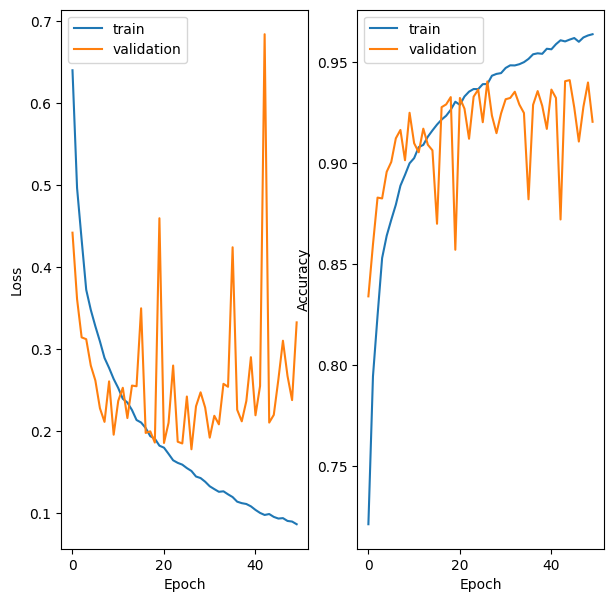

In [25]:
# Loss
plt.subplot(1, 2, 1)
plt.plot(history_dcnn_over.history['loss'])
plt.plot(history_dcnn_over.history['val_loss'])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['train', 'validation'])

# Accuracy
plt.subplot(1, 2, 2)
plt.plot(history_dcnn_over.history['accuracy'])
plt.plot(history_dcnn_over.history['val_accuracy'])
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['train', 'validation'])

# Load Model

In [26]:
os.chdir('C:/Users/marco/Desktop/Local_Documents/models/Processing_Enanch_Oversampling_Augm')

In [36]:
# Load model
net_dcnn_112_process_enanch_over = keras.models.load_model("dcnn_model_112_v1_val_acc_best.hdf5")

In [37]:
# Load hystory and convert to dict
history = np.load('dcnn_history_112_v1.npy', allow_pickle=True).item()

# Model Evaluation

In [29]:
# Set visualization size for figures 
plt.rcParams['figure.figsize'] = [5,5] # width, height

In [30]:
CATEGORIES = "COVID", "NORMAL","PNEUMONIA"

In [31]:
history.keys()

dict_keys(['loss', 'accuracy', 'precision', 'recall', 'auc', 'top 2 accuracy', 'val_loss', 'val_accuracy', 'val_precision', 'val_recall', 'val_auc', 'val_top 2 accuracy'])

In [32]:
%matplotlib inline

def print_graph(item, index, history):
    plt.figure()
    train_values = history[item][0:index]
    plt.plot(train_values)
    test_values = history['val_' + item][0:index]
    plt.plot(test_values)
    plt.legend(['training','validation'])
    plt.title('Training and validation '+ item)
    plt.xlabel('epoch')
    plt.show()
    plot = '{}.png'.format(item)
    plt.savefig(plot)

In [39]:
def test_set_results(pred_value, n=1):    
    y_test = test_data.labels
    X_test, _ = test_data.next()
    
    corr_pred = confusion_matrix(y_test, pred_value)
    fig=plt.figure(figsize=(5, 5))
    ax = plt.axes()
    
    sns.heatmap(corr_pred,annot=True, fmt="d",cmap="Purples", xticklabels=CATEGORIES, yticklabels=CATEGORIES)
    ax.set_title('Confusione Matrix')
    plt.show()
    
    n_correct = int(corr_pred[0][0] + corr_pred[1][1] + corr_pred[2][2])
    print('...'*15)

    print('> Correct Predictions:', n_correct)
    
    n_wrongs = len(y_test) - n_correct
    print('> Wrong Predictions:', n_wrongs)
    print('...'*15)
    
    print(classification_report(test_data.labels, pred_value, target_names=CATEGORIES))

In [34]:
def printResults(name, model):
    predictions = model.predict(test_data, verbose=1)
    preds = np.argmax(predictions, axis=1)
    test_set_results(preds)

In [35]:
def model_summary(model, history, name):
    val_acc = history['val_accuracy'] #validation accuracy history
    index= val_acc.index(max(val_acc))
    print('Best Epochs:', index)


    test_loss, test_accuracy, test_precision, test_recall, auc, _, = model.evaluate(test_data, verbose=1)

    train_accuracy = history['accuracy'][index]
    train_loss = history['loss'][index]

    print_graph('loss', index, history)
    print_graph('accuracy', index, history)

    print('---'*15) 
    print(name)
    print('> Accuracy on train:',round(train_accuracy, 2), 
            '\tLoss on train:', round(train_loss,2))
    

    print('> Accuracy on test:',round(test_accuracy, 2),
            '\tLoss on test:',round(test_loss,2))

    print('---'*15)
    print('> predicting test')
    print('---'*15)

    printResults(name, model)

Best Epochs: 44
13/13 [==============================] - 1s 45ms/step - loss: 0.4284 - accuracy: 0.8766 - precision: 0.8785 - recall: 0.8741 - auc: 0.9712 - top 2 accuracy: 0.9849


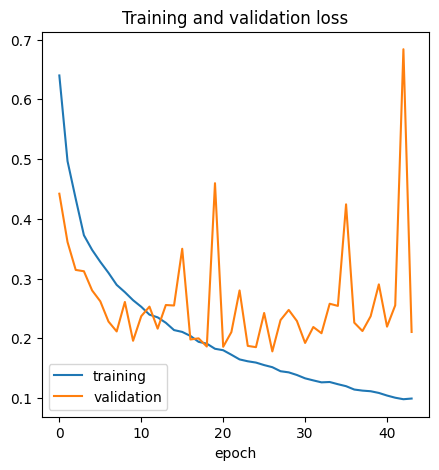

<Figure size 500x500 with 0 Axes>

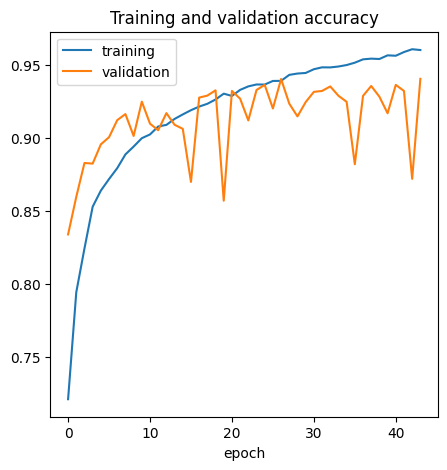

---------------------------------------------
DCCN - Oversampling - Preprocessing - Enanchment
> Accuracy on train: 0.96 	Loss on train: 0.1
> Accuracy on test: 0.88 	Loss on test: 0.43
---------------------------------------------
> predicting test
---------------------------------------------
13/13 [==============================] - 0s 28ms/step


<Figure size 500x500 with 0 Axes>

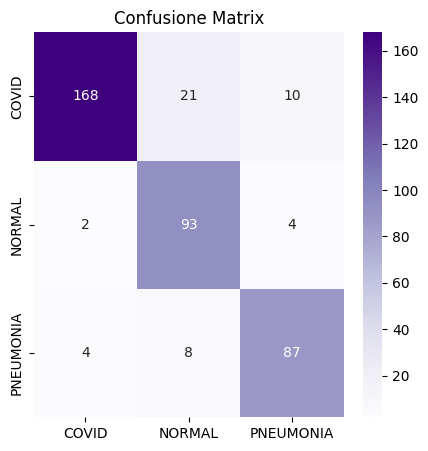

.............................................
> Correct Predictions: 348
> Wrong Predictions: 49
.............................................
              precision    recall  f1-score   support

       COVID       0.97      0.84      0.90       199
      NORMAL       0.76      0.94      0.84        99
   PNEUMONIA       0.86      0.88      0.87        99

    accuracy                           0.88       397
   macro avg       0.86      0.89      0.87       397
weighted avg       0.89      0.88      0.88       397



In [41]:
model_summary(net_dcnn_112_process_enanch_over, history, 'DCCN - Oversampling - Preprocessing - Enanchment')